Epoch 1/50, Train Loss: 0.151088, Val Loss: 0.058489
Epoch 2/50, Train Loss: 0.026011, Val Loss: 0.006169
Epoch 3/50, Train Loss: 0.010528, Val Loss: 0.005278
Epoch 4/50, Train Loss: 0.008165, Val Loss: 0.026785
Epoch 5/50, Train Loss: 0.006452, Val Loss: 0.000919
Epoch 6/50, Train Loss: 0.006085, Val Loss: 0.044324
Epoch 7/50, Train Loss: 0.005927, Val Loss: 0.002575
Epoch 8/50, Train Loss: 0.005395, Val Loss: 0.001230
Epoch 9/50, Train Loss: 0.004857, Val Loss: 0.008059
Epoch 10/50, Train Loss: 0.004814, Val Loss: 0.001507
Epoch 11/50, Train Loss: 0.004083, Val Loss: 0.006389
Epoch 12/50, Train Loss: 0.003991, Val Loss: 0.001042
Epoch 13/50, Train Loss: 0.003675, Val Loss: 0.003748
Epoch 14/50, Train Loss: 0.003350, Val Loss: 0.002482
Epoch 15/50, Train Loss: 0.003299, Val Loss: 0.002807
Epoch 16/50, Train Loss: 0.003709, Val Loss: 0.000956
Epoch 17/50, Train Loss: 0.003065, Val Loss: 0.001106
Epoch 18/50, Train Loss: 0.002628, Val Loss: 0.000998
Epoch 19/50, Train Loss: 0.003234, Va

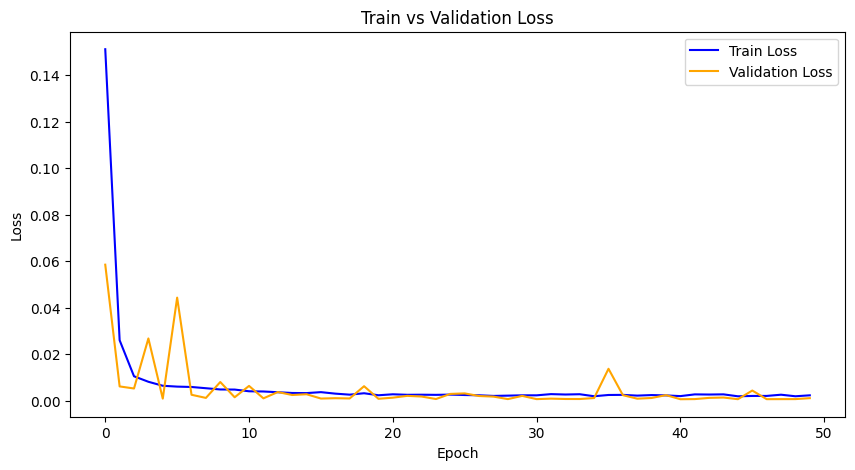

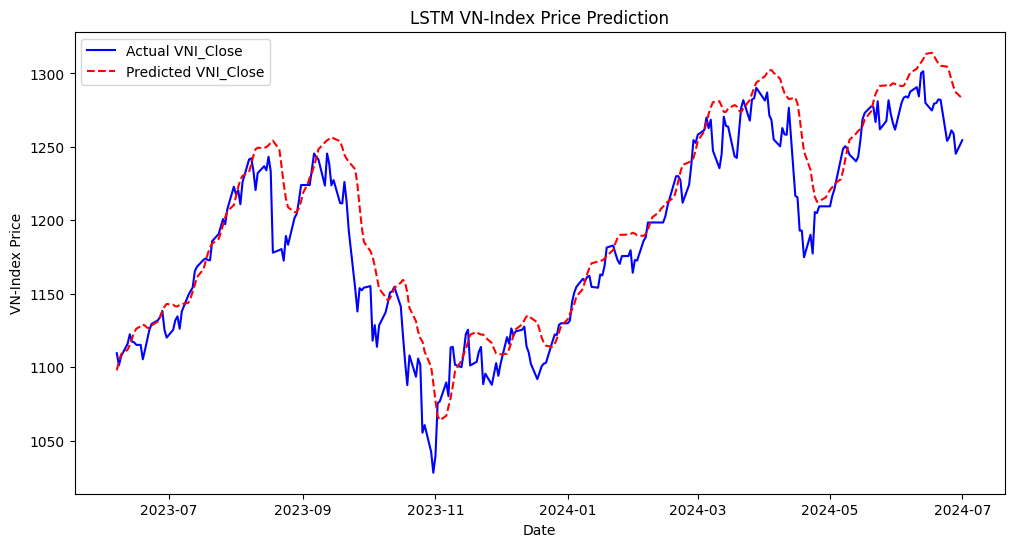

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# Đọc dữ liệu

df = pd.read_csv(r"C:\Users\Admin\Downloads\NCKH_\MODEL\Data\data_base.csv")

# Chuyển đổi cột Date thành datetime và đặt làm index
df['Date'] = pd.to_datetime(df['Date'], format="%m/%d/%Y")
df.set_index('Date', inplace=True)
# Xác định cột mục tiêu và features
target_col = 'VNI_Close price'
feature_cols = [col for col in df.columns if col != target_col]

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

train_size = int(len(df) * 0.8)
val_size = int(len(df) * 0.1)

train_data = df_scaled.iloc[:train_size]
val_data = df_scaled.iloc[train_size:train_size + val_size]
test_data = df_scaled.iloc[train_size + val_size:]

def create_sequences(data, seq_length=60):
    sequences, targets = [], []
    data_values = data.values
    for i in range(len(data) - seq_length):
        sequences.append(data_values[i:i + seq_length])
        targets.append(data_values[i + seq_length][data.columns.get_loc(target_col)])
    return torch.tensor(np.array(sequences), dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

seq_length = 60
X_train, y_train = create_sequences(train_data, seq_length)
X_val, y_val = create_sequences(val_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=0.5)
        self.batchnorm = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.batchnorm(lstm_out[:, -1, :])
        out = self.fc(out)
        return out.squeeze()

input_size = X_train.shape[2]
model = LSTMModel(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        y_pred = model(batch_X)
        loss = criterion(y_pred, batch_y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    train_losses.append(epoch_train_loss / len(train_loader))
    
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            y_pred = model(batch_X)
            loss = criterion(y_pred, batch_y)
            epoch_val_loss += loss.item()
    
    val_losses.append(epoch_val_loss / len(val_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_losses[-1]:.6f}")

torch.save(model.state_dict(), "lstm_base.pth")
print("✅ Training hoàn tất! Mô hình đã được lưu.")

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss", color='blue')
plt.plot(val_losses, label="Validation Loss", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.show()

model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        y_pred = model(batch_X)
        predictions.extend(y_pred.cpu().numpy())
        actuals.extend(batch_y.numpy())

actuals = np.array(actuals).reshape(-1, 1)
predictions = np.array(predictions).reshape(-1, 1)

scaler_target = MinMaxScaler()
scaler_target.fit(df[[target_col]])
actuals = scaler_target.inverse_transform(actuals)
predictions = scaler_target.inverse_transform(predictions)

plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(actuals):], actuals, label="Actual VNI_Close", color='blue')
plt.plot(df.index[-len(predictions):], predictions, label="Predicted VNI_Close", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("VN-Index Price")
plt.legend()
plt.title("LSTM VN-Index Price Prediction")
plt.show()


In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Tính các chỉ số đánh giá
mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)

print(f"Test MAE: {mae:.2f}")
print(f"Test MSE: {mse:.2f}")
print(f"Test RMSE: {rmse:.2f}")

Test MAE: 17.70
Test MSE: 619.60
Test RMSE: 24.89


In [23]:
print("📌 Số lượng features khi train:", len(feature_cols))  # Kiểm tra số lượng cột thực tế
print("📌 Danh sách features khi train:", feature_cols)  # In danh sách cột để kiểm tra


📌 Số lượng features khi train: 4
📌 Danh sách features khi train: ['VNI_Open price', 'VNI_High price', 'VNI_Low price', 'VNI_Volume']


✅ RMSE: 15.6151
✅ MAE: 13.2766
✅ MAPE: 1.05%
✅ MSE: 243.8318


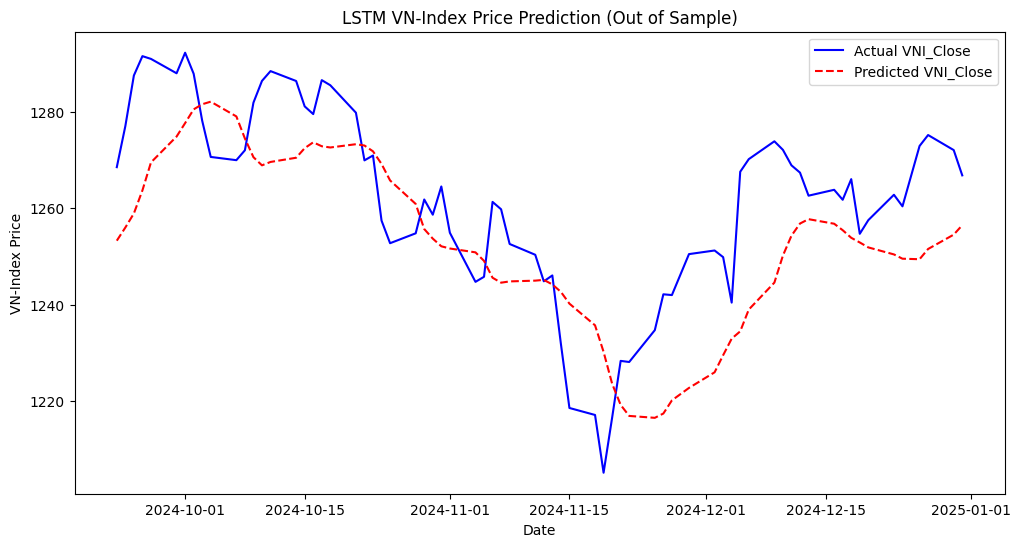

In [38]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load dữ liệu OOS
file_path = r"C:\Users\Admin\Downloads\NCKH_\MODEL\Data\data_OOS_2.csv"  # Đổi thành đường dẫn chính xác
df_oos = pd.read_csv(file_path)
df_oos = df_oos[['Date','VNI_Volume','VNI_Close price','VNI_Open price', 'VNI_High price', 'VNI_Low price']]  # Chỉ giữ các cột đã dùng khi train
# Chuyển đổi cột Date thành datetime và đặt làm index
df_oos['Date'] = pd.to_datetime(df_oos['Date'], format="%m/%d/%Y")
df_oos.set_index('Date', inplace=True)

# Xác định cột mục tiêu
target_col = 'VNI_Close price'

# Giữ đúng các cột feature như trong dữ liệu training
feature_cols = [col for col in df_oos.columns if col != target_col]
df_oos = df_oos[[target_col] + feature_cols]  # Đảm bảo thứ tự cột

# Chuẩn hóa dữ liệu OOS
scaler = MinMaxScaler()
df_oos_scaled = pd.DataFrame(scaler.fit_transform(df_oos), columns=df_oos.columns, index=df_oos.index)

# Hàm tạo sequences
def create_sequences(data, seq_length=60):
    sequences = []
    data_values = data.values
    for i in range(len(data) - seq_length):
        sequences.append(data_values[i:i + seq_length])
    return torch.tensor(np.array(sequences), dtype=torch.float32)

# Tạo dữ liệu OOS
seq_length = 60
X_oos = create_sequences(df_oos_scaled, seq_length)

# Định nghĩa lại mô hình LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5)
        self.batchnorm = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.batchnorm(lstm_out[:, -1, :])
        out = self.fc(out)
        return out.squeeze()

# Load lại mô hình đã train
input_size = X_oos.shape[2]
model_lstm = LSTMModel(input_size)
model_lstm.load_state_dict(torch.load("lstm_base.pth", map_location=torch.device("cpu")))
model_lstm.eval()

# Dự đoán theo batch nhỏ để tránh quá tải bộ nhớ
batch_size = 32
predictions_oos_lstm = []

with torch.no_grad():
    for i in range(0, len(X_oos), batch_size):
        batch_X = X_oos[i:i + batch_size]
        y_pred = model_lstm(batch_X).cpu().numpy()
        predictions_oos_lstm.extend(y_pred)

# Chuyển về giá trị gốc
predictions_oos_lstm = np.array(predictions_oos_lstm).reshape(-1, 1)
scaler_target = MinMaxScaler()
scaler_target.fit(df_oos[[target_col]])
predictions_oos_lstm = scaler_target.inverse_transform(predictions_oos_lstm)

# Tính RMSE, MAE, MAPE
actual_values_oos = df_oos[target_col].iloc[-len(predictions_oos_lstm):].values

rmse_lstm = np.sqrt(mean_squared_error(actual_values_oos, predictions_oos_lstm))
mae_lstm = mean_absolute_error(actual_values_oos, predictions_oos_lstm)
mape_lstm = np.mean(np.abs((actual_values_oos - predictions_oos_lstm.flatten()) / actual_values_oos)) * 100
mse_lstm = mean_squared_error(actual_values_oos, predictions_oos_lstm)
# In kết quả
print(f"✅ RMSE: {rmse_lstm:.4f}")
print(f"✅ MAE: {mae_lstm:.4f}")
print(f"✅ MAPE: {mape_lstm:.2f}%")

print(f"✅ MSE: {mse_lstm:.4f}")

# Vẽ biểu đồ Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(df_oos.index[-len(predictions_oos_lstm):], actual_values_oos, label="Actual VNI_Close", color='blue')
plt.plot(df_oos.index[-len(predictions_oos_lstm):], predictions_oos_lstm, label="Predicted VNI_Close", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("VN-Index Price")
plt.legend()
plt.title("LSTM VN-Index Price Prediction (Out of Sample)")
plt.show()


In [25]:
print("📌 Số lượng features khi OOS:", df_oos.shape[1])
print("📌 Danh sách features khi OOS:", df_oos.columns.tolist())


📌 Số lượng features khi OOS: 5
📌 Danh sách features khi OOS: ['VNI_Close price', 'VNI_Volume', 'VNI_Open price', 'VNI_High price', 'VNI_Low price']


In [39]:
# Tạo DataFrame kết quả dự đoán
predictions_df = pd.DataFrame({
    "Date": df_oos.index[-len(predictions_oos_lstm):],  # Ngày dự đoán
    "Actual VNI_Close": actual_values_oos.flatten(),  # Giá thực tế
    "Predicted VNI_Close": predictions_oos_lstm.flatten()  # Giá dự đoán
})

# In bảng kết quả
print("\n📊 Bảng kết quả dự đoán:")
print(predictions_df.tail(20).to_string(index=False))  # In 20 dòng cuối

predictions_df.head(10)

predictions_df.to_csv("lstm_base_OOS_predictions.csv")



📊 Bảng kết quả dự đoán:
      Date  Actual VNI_Close  Predicted VNI_Close
2024-12-03           1249.83          1229.506958
2024-12-04           1240.41          1232.936401
2024-12-05           1267.53          1234.457031
2024-12-06           1270.14          1238.960815
2024-12-09           1273.84          1244.552124
2024-12-10           1272.07          1250.152710
2024-12-11           1268.86          1254.275269
2024-12-12           1267.35          1256.796021
2024-12-13           1262.57          1257.700806
2024-12-16           1263.79          1256.756348
2024-12-17           1261.72          1255.416138
2024-12-18           1266.00          1253.839844
2024-12-19           1254.67          1252.872681
2024-12-20           1257.50          1251.849976
2024-12-23           1262.76          1250.395630
2024-12-24           1260.36          1249.506714
2024-12-26           1272.87          1249.398682
2024-12-27           1275.14          1251.521973
2024-12-30           1272

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Tính các chỉ số đánh giá
mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)

print(f"Test MAE: {mae:.2f}")
print(f"Test MSE: {mse:.2f}")
print(f"Test RMSE: {rmse:.2f}")


Test MAE: 14.61
Test MSE: 421.66
Test RMSE: 20.53


Baseline RMSE: 0.0172

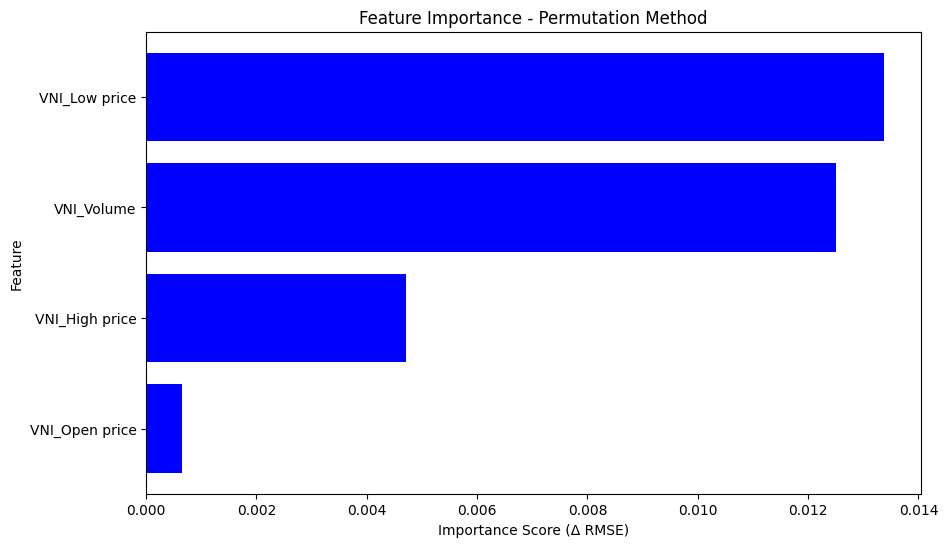

In [28]:
from sklearn.metrics import mean_squared_error
import copy

# Dự đoán ban đầu trên tập test (để lấy baseline RMSE)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    predictions = model(X_test.to(device)).cpu().numpy()
baseline_rmse = np.sqrt(mean_squared_error(y_test.numpy(), predictions))
print(f"Baseline RMSE: {baseline_rmse:.4f}")

# Tính Feature Importance bằng cách hoán đổi từng feature
feature_importance = {}
for i, feature in enumerate(feature_cols):
    X_test_permuted = X_test.clone()
    np.random.shuffle(X_test_permuted[:, :, i].numpy())  # Xáo trộn feature thứ i

    # Dự đoán lại
    with torch.no_grad():
        permuted_predictions = model(X_test_permuted.to(device)).cpu().numpy()
    
    # Tính RMSE sau khi hoán đổi
    permuted_rmse = np.sqrt(mean_squared_error(y_test.numpy(), permuted_predictions))
    importance_score = permuted_rmse - baseline_rmse  # Feature nào làm tăng RMSE nhiều là quan trọng hơn
    feature_importance[feature] = importance_score

# Sắp xếp theo độ quan trọng giảm dần
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Vẽ biểu đồ Feature Importance
plt.figure(figsize=(10, 6))
plt.barh([x[0] for x in sorted_features], [x[1] for x in sorted_features], color='blue')
plt.xlabel("Importance Score (Δ RMSE)")
plt.ylabel("Feature")
plt.title("Feature Importance - Permutation Method")
plt.gca().invert_yaxis()  # Đảo ngược để feature quan trọng nhất ở trên cùng
plt.show()


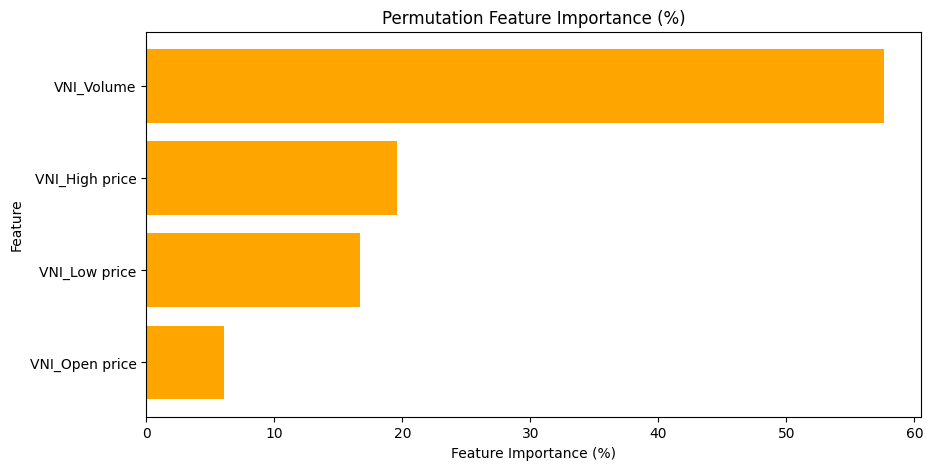

In [36]:
from sklearn.metrics import mean_squared_error

def permutation_importance(model, X_test, y_test, feature_cols, scaler_target):
    baseline_preds = model(X_test.to(device)).cpu().detach().numpy()
    baseline_preds = scaler_target.inverse_transform(baseline_preds.reshape(-1, 1))
    y_test = scaler_target.inverse_transform(y_test.numpy().reshape(-1, 1))
    baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_preds))

    importance_scores = {}

    for i, col in enumerate(feature_cols):
        X_test_permuted = X_test.clone()
        permuted_col = X_test_permuted[:, :, i]
        permuted_col[:] = permuted_col[torch.randperm(permuted_col.shape[0])]  # Xáo trộn giá trị cột

        permuted_preds = model(X_test_permuted.to(device)).cpu().detach().numpy()
        permuted_preds = scaler_target.inverse_transform(permuted_preds.reshape(-1, 1))

        permuted_rmse = np.sqrt(mean_squared_error(y_test, permuted_preds))
        importance_scores[col] = permuted_rmse - baseline_rmse  # Chênh lệch RMSE

    # Chuyển đổi sang % importance
    total_importance = sum(importance_scores.values())
    importance_percent = {k: (v / total_importance) * 100 for k, v in importance_scores.items()}

    return importance_percent

# Chạy tính toán importance
X_test_tensor, y_test_tensor = X_test.to(device), y_test.to(device)
feature_importance = permutation_importance(model, X_test_tensor, y_test_tensor, feature_cols, scaler_target)
import matplotlib.pyplot as plt

# Sắp xếp feature importance theo giá trị giảm dần
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
features, importance_values = zip(*sorted_importance)

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
plt.barh(features, importance_values, color='orange')
plt.xlabel("Feature Importance (%)")
plt.ylabel("Feature")
plt.title("Permutation Feature Importance (%)")
plt.gca().invert_yaxis()  # Đảo ngược trục Y để feature quan trọng nhất nằm trên cùng
plt.show()
